# Timm - Unet for neutrophile cell segmentation

In [62]:
# Ensure fallback is enabled
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [63]:
# Imports
from fastai.vision.all import *
import timm
from timm.models.layers import create_attn, get_attn
import pdb
from pathlib import Path
import numpy as np
from PIL import Image
import os

In [64]:
# Defineing dice score metric
def dice(input, targs, iou=False, eps=1e-8,sz=256):
    #threshold for the number of predicted pixels
    noise_th = 75.0*(sz/128.0)**2 
    best_thr0 = 0.2
    n = targs.shape[0]
    #input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = torch.sigmoid(input).view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

## Data pipeline

### Preprocessing

In [65]:
# Load the .npy files
images_path = 'data/Challenge/images.npy'
labels_path = 'data/Challenge/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

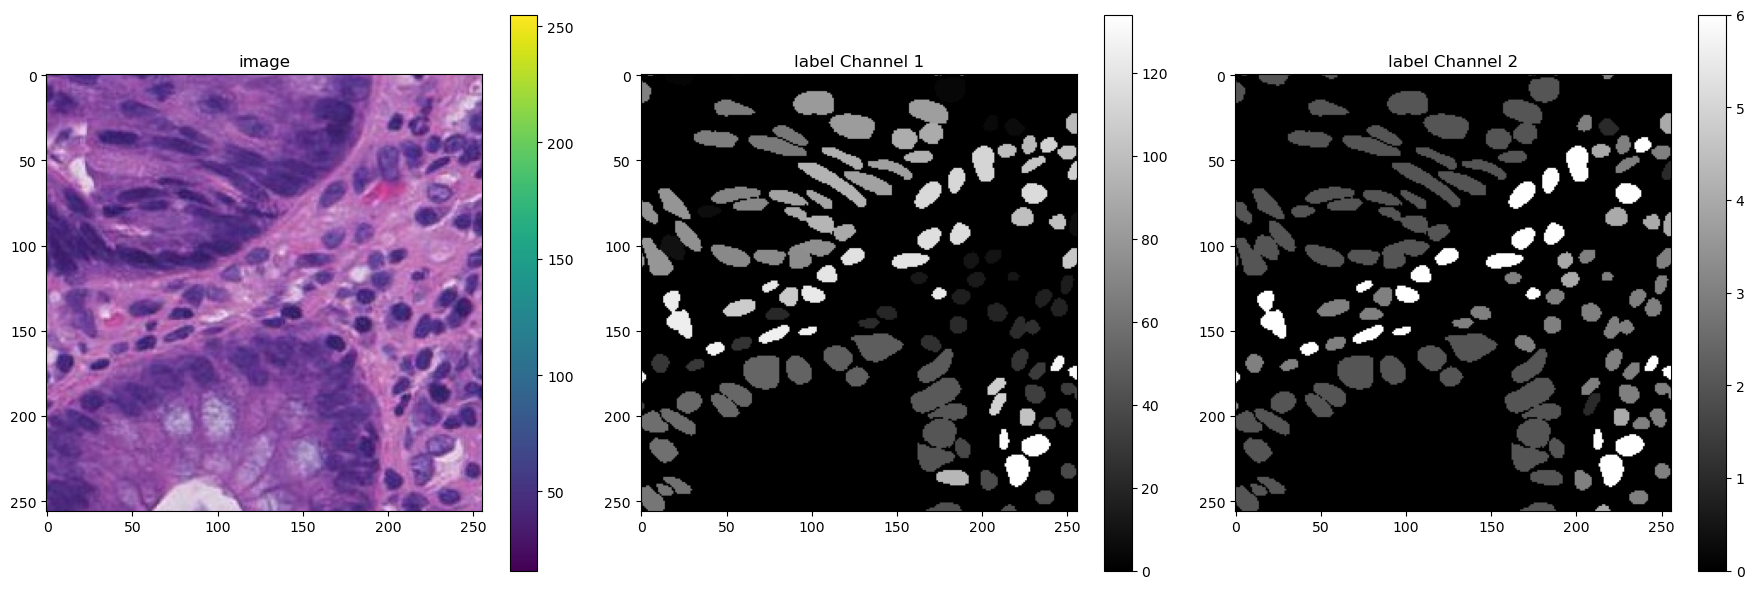

In [66]:
# Function to plot an individual channel
def plot_channel(img, title, ax, fig, cmap='gray'):
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

# Function to plot image and its corresponding label
def plot_img_label(img, lbl, img_title="image", lbl_title="label"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust for 3 subplots

    # Plot the image
    if img.ndim == 2 or img.shape[-1] == 1:
        # Grayscale image
        plot_channel(img, img_title, axs[0], fig, cmap='gray')
    elif img.shape[-1] == 3:
        # RGB image
        plot_channel(img, img_title, axs[0], fig, cmap=None)

    # Plot each channel of the label separately
    for i in range(2):
        plot_channel(lbl[..., i], f"{lbl_title} Channel {i+1}", axs[i+1], fig)

    plt.tight_layout()

# Example usage
i = 3333
img, lbl = images[i], labels[i]
assert img.ndim in (2,3)
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]
plot_img_label(img, lbl)

In [67]:
# Filter out all cells except for Neutrophil cells:
classification_maps = labels[:, :, :, 1]
labels = classification_maps

In [ ]:
# Create binary masks for Neutrophil cells (class 1)
neutrophil_masks = (classification_maps == 1).astype(np.uint16)

labels = neutrophil_masks

In [68]:
# Total number of images
print(f"Number of images: {len(images)} and labels: {len(labels)}")

Number of images: 4981 and labels: 4981


In [8]:
# Assuming images is a list of your images and labels is a list of your labels
filtered_images = []
filtered_labels = []

for i in range(len(images)):
    # Check if the neutrophil mask contains any non-zero values (presence of neutrophil cells)
    if np.any(labels[i]):
        filtered_images.append(images[i])
        filtered_labels.append(labels[i])

# Replace the original lists with the filtered lists
images = filtered_images
labels = filtered_labels
print(f"Number of images: {len(images)} and labels: {len(labels)}")

Number of images: 1218 and labels: 1218


In [69]:
# Create directories for the images and labels if they don't exist
images_dir = 'data/train_ALLMASKS/images'
labels_dir = 'data/train_ALLMASKS/labels'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

def save_image(array, path):
    img = Image.fromarray(array)
    img.save(path)

for i in range(len(images)):
    # Use the same base name for both image and label
    base_name = f'{i:03d}.png'
    
    # Save the image
    img_path = os.path.join(images_dir, base_name)
    save_image(images[i], img_path)
    
    # Process and save the label
    label_processed = np.where(labels[i] == 1, 255, 0).astype(np.uint8)  # Convert 1s to 255
    label_path = os.path.join(labels_dir, base_name)
    save_image(label_processed, label_path)

# Return the paths to the first few saved images and labels for verification
sample_paths = [os.path.join(images_dir, f'{i:03d}.png') for i in range(3)] + \
                [os.path.join(labels_dir, f'{i:03d}.png') for i in range(3)]
sample_paths

['data/train_ALLMASKS/images/000.png',
 'data/train_ALLMASKS/images/001.png',
 'data/train_ALLMASKS/images/002.png',
 'data/train_ALLMASKS/labels/000.png',
 'data/train_ALLMASKS/labels/001.png',
 'data/train_ALLMASKS/labels/002.png']

In [53]:
import os
import numpy as np
from PIL import Image

# Create directories for the images and labels if they don't exist
images_dir = 'data/train_ALLMASKS/images'
labels_dir = 'data/train_ALLMASKS/labels'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

def save_image(array, path):
    img = Image.fromarray(array)
    img.save(path)

def process_label(label):
    # Map each label to a specific intensity
    # Intensities are spaced equally from 0 to 255 over the label range (0 to 6 in this case)
    label_intensities = np.linspace(0, 255, num=7).astype(np.uint8)
    label_processed = np.zeros_like(label, dtype=np.uint8)
    for i in range(7):  # Assuming labels go from 0 to 6
        label_processed[label == i] = label_intensities[i]
    return label_processed

for i in range(len(images)):
    # Use the same base name for both image and label
    base_name = f'{i:03d}.png'
    
    # Save the image
    img_path = os.path.join(images_dir, base_name)
    save_image(images[i], img_path)
    
    # Process and save the label
    label_processed = process_label(labels[i])
    label_path = os.path.join(labels_dir, base_name)
    save_image(label_processed, label_path)

# Return the paths to the first few saved images and labels for verification
sample_paths = [os.path.join(images_dir, f'{i:03d}.png') for i in range(3)] + \
                [os.path.join(labels_dir, f'{i:03d}.png') for i in range(3)]
sample_paths

['data/train_ALLMASKS/images/000.png',
 'data/train_ALLMASKS/images/001.png',
 'data/train_ALLMASKS/images/002.png',
 'data/train_ALLMASKS/labels/000.png',
 'data/train_ALLMASKS/labels/001.png',
 'data/train_ALLMASKS/labels/002.png']

### Datablock

In [70]:
data_path = Path('data/')
size=256
bs=64
def get_data(size,tfms=None,bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),*aug_transforms()]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=RandomSplitter(valid_pct=0.1,seed=2021),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','labels'))
    return db.dataloaders(source=data_path/'train_ALLMASKS'/'images',bs=bs)

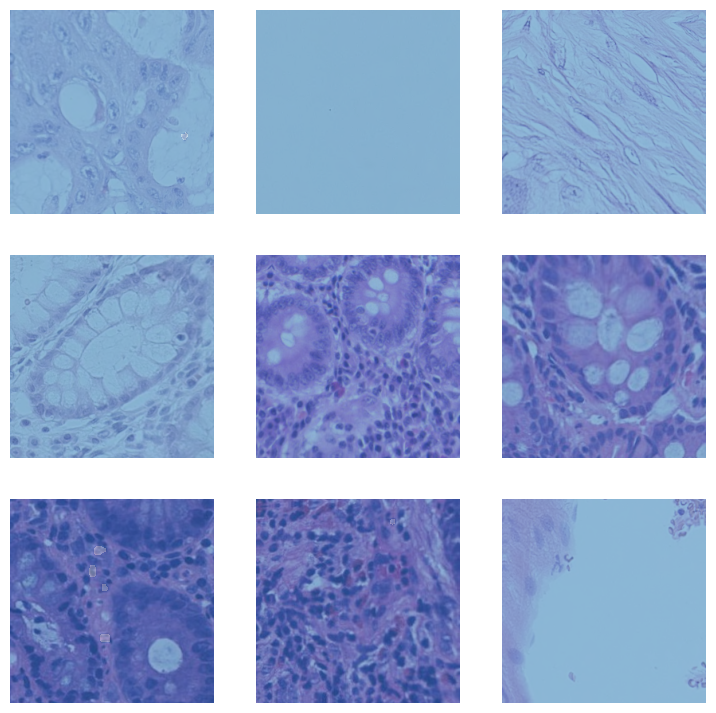

In [71]:
dls = get_data(size=256,bs=64)
dls.show_batch(max_n=9)

### Training the Unet

In [9]:
dls = get_data(size=256,bs=16)
learn = unet_learner(dls, resnet34, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(5)

/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,dice,time
0,0.007951,0.009020,0.755020,12:10


epoch,train_loss,valid_loss,dice,time
0,0.007249,0.007470,0.755020,23:57
1,0.006816,0.007584,0.736459,12:25
2,0.004482,0.005717,0.771109,12:35
3,0.004631,0.005150,0.790102,13:03
4,0.003967,0.004842,0.786424,13:42


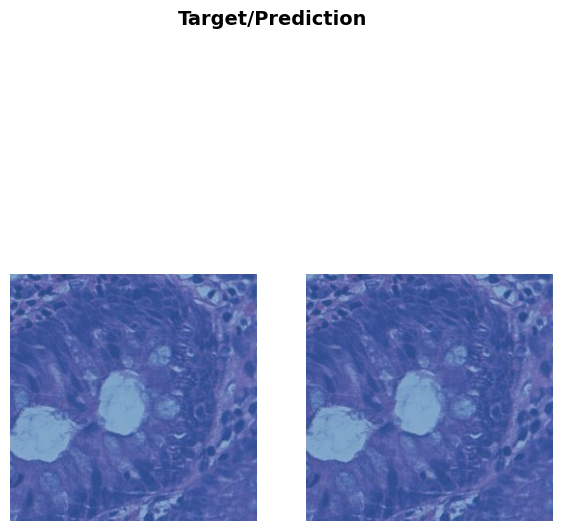

In [11]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

In [24]:
# Smaller model more epochs on Neutrophil images only
dls = get_data(size=256,bs=16)
learn = unet_learner(dls, resnet18, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(50)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/marcusnsr/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 9.33MB/s]
/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,dice,time
0,0.047174,0.025304,0.000000,05:24


epoch,train_loss,valid_loss,dice,time
0,0.022007,0.020292,0.013433,04:10
1,0.020045,0.018772,0.030624,03:56
2,0.019664,0.018758,0.091087,04:06
3,0.018073,0.016700,0.077554,04:28
4,0.017967,0.016402,0.132900,04:03
5,0.017397,0.017645,0.140634,04:01
6,0.017132,0.018125,0.058527,04:13
7,0.016301,0.015143,0.092303,04:10
8,0.016222,0.015331,0.082513,04:14
9,0.015962,0.015542,0.070164,04:20


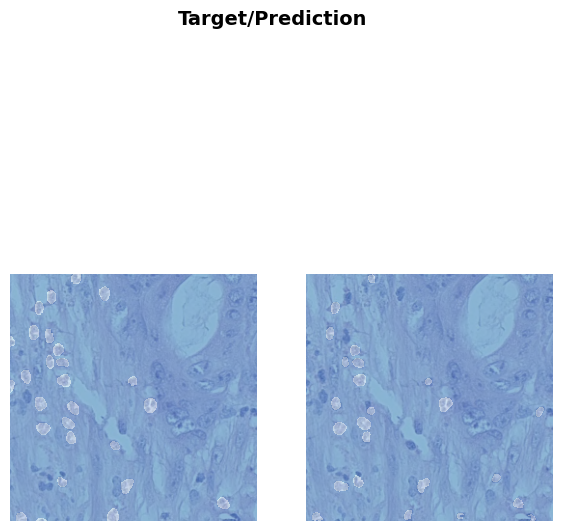

In [38]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

In [57]:
# Smaller model more epochs on ALL MASKS
dls = get_data(size=256,bs=16)
learn = unet_learner(dls, resnet18, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(20)

epoch,train_loss,valid_loss,dice,time
0,0.098197,0.101383,0.329030,12:49


epoch,train_loss,valid_loss,dice,time
0,0.069076,0.064831,0.507694,14:26
1,0.061820,0.059704,0.556631,15:31
2,0.060082,0.056661,0.573360,15:49
3,0.057574,0.055776,0.587073,15:43
4,0.053278,0.051636,0.602930,15:32
5,0.053246,0.052781,0.586701,14:15
6,0.051487,0.047334,0.618830,13:41
7,0.049797,0.048937,0.634764,13:53
8,0.046337,0.054874,0.558747,13:47
9,0.045779,0.045746,0.634396,13:38


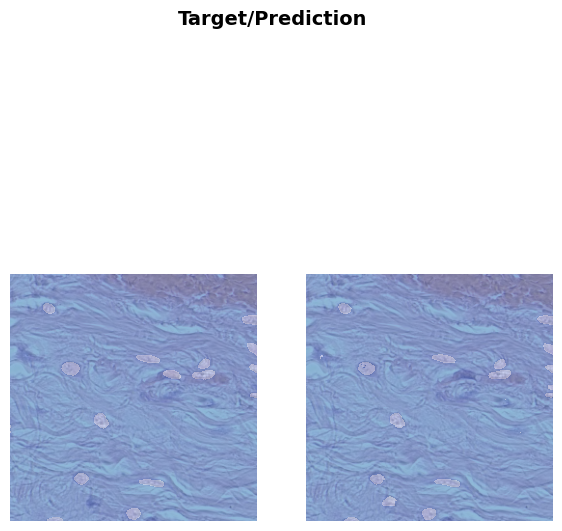

In [60]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

## Unet using Timm

In [10]:
# Defining the encoder
class Encoder(Module):
    def __init__(self, model_name='resnext50_32x4d'):
        self.encoder = timm.create_model(model_name, features_only=True, pretrained=True)
        
    def forward(self, x):
        return self.encoder(x)

In [11]:
# List of available models (pretrained)
timm_models = timm.list_models(pretrained=True)

In [22]:
# Find all models that contain "resnext" in their name
resnext_models = [model for model in timm_models if 'resnet' in model]
resnext_models

['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_i

In [13]:
# Find the resnet model
timm_models.index('resnet50d.a1_in1k')

792

In [14]:
# Create a dummy batch
dummy_batch = torch.rand((2,3,224,224))
enc = Encoder('resnet50d.a1_in1k')

In [15]:
# Pass the dummy batch through the encoder
for o in enc(dummy_batch):
    print(o.shape)

torch.Size([2, 64, 112, 112])
torch.Size([2, 256, 56, 56])
torch.Size([2, 512, 28, 28])
torch.Size([2, 1024, 14, 14])
torch.Size([2, 2048, 7, 7])


### Define the UnetBlock

In [16]:
from timm.models.layers import create_attn, get_attn

In [17]:
# Define the UnetBlock
class UnetBlock(Module):
    def __init__(self,in_channels,chanels,out_channels,attn=None):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        self.attn_layer = attn(out_channels) if attn else noop
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attn_layer(x)
        return x

### Creating the Hyper Cols

In [18]:
# Define the Hyper Columns
def calc_hyperfeats(d1,d2,d3,d4,d5):
    hyperfeats = torch.cat((
                         d1,
                         F.interpolate(d2, scale_factor=2, mode='bilinear',align_corners=False),
                         F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
                         F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False),
                         F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False)), 1)
    return hyperfeats

### Connect Encoder and Decoder

In [19]:
class UnetDecoder(Module):
    def __init__(self, fs=32, expansion=4,n_out=1, hypercol=False,attn=None):
        center_ch = 512*expansion
        decoder5_ch = center_ch + (256*expansion)
        channels = 512
        self.hypercol = hypercol
        self.center = nn.Sequential(ConvLayer(center_ch,center_ch),ConvLayer(center_ch,center_ch//2))
        self.decoder5 = UnetBlock(decoder5_ch,channels,fs,attn) 
        self.decoder4 = UnetBlock(256*expansion+fs,256,fs,attn) 
        self.decoder3 = UnetBlock(128*expansion+fs,128,fs,attn)
        self.decoder2 = UnetBlock(64*expansion+fs,64,fs,attn)
        self.decoder1 = UnetBlock(fs,fs,fs,attn)
        if hypercol:
            self.logit = nn.Sequential(ConvLayer(fs*5,fs*2),ConvLayer(fs*2,fs),nn.Conv2d(fs,n_out,kernel_size=1))
        else:
            self.logit = nn.Sequential(ConvLayer(fs,fs//2),ConvLayer(fs//2,fs//2),nn.Conv2d(fs//2,n_out,kernel_size=1))
        
    def forward(self, feats):
        e1,e2,e3,e4,e5 = feats #'64 256 512 1024 2048'
        f = self.center(e5)
        d5 = self.decoder5(torch.cat([f, e5], 1))
        d4 = self.decoder4(torch.cat([d5, e4], 1))
        d3 = self.decoder3(torch.cat([d4, e3], 1))
        d2 = self.decoder2(torch.cat([d3, e2], 1))
        d1 = self.decoder1(d2)
        return self.logit(calc_hyperfeats(d1,d2,d3,d4,d5)) if self.hypercol else self.logit(d1)
    
        
class Unet(Module):
    def __init__(self, fs=32, expansion=4, model_name='resnext50_32x4d',n_out=1,hypercol=False,attn=None):
        self.encoder = Encoder(model_name)
        self.decoder = UnetDecoder(fs=fs, expansion=expansion,n_out=n_out,hypercol=hypercol,attn=attn)
        
    def forward(self, x):
        feats = self.encoder(x) #'64 256 512 1024 2048'
        out = self.decoder(feats)
        return out

In [20]:
# Splitter (Discriminative Learning)
def unet_splitter(m): return L(m.encoder,m.decoder).map(params)

## Training simple Unet

In [61]:
# All images
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34'),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

model.safetensors: 100%|██████████| 87.3M/87.3M [00:13<00:00, 6.45MB/s]


epoch,train_loss,valid_loss,dice,time
0,0.245122,0.150569,0.351690,02:58


epoch,train_loss,valid_loss,dice,time
0,0.095876,0.076139,0.755020,03:25
1,0.040460,0.028127,0.755020,03:42
2,0.018439,0.016336,0.755020,03:58
3,0.012785,0.012789,0.758584,03:32
4,0.011262,0.012175,0.762117,03:43


In [63]:
# Neutrophil images only
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34'),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.517916,0.418201,0.009584,00:43


epoch,train_loss,valid_loss,dice,time
0,0.393135,0.359166,0.009580,00:50
1,0.342606,0.283438,0.009585,00:49
2,0.286515,0.222889,0.005171,00:51
3,0.244436,0.194258,0.021578,01:00
4,0.219676,0.193112,0.050046,01:20


In [23]:
# Smaller model more epochs on Neutrophil images only
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet10t.c3_in1k'),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(20)

model.safetensors: 100%|██████████| 21.8M/21.8M [00:02<00:00, 9.04MB/s]


epoch,train_loss,valid_loss,dice,time
0,0.561239,0.416322,0.009659,01:10


epoch,train_loss,valid_loss,dice,time
0,0.391305,0.375869,0.009580,01:05
1,0.372702,0.356083,0.009581,01:02
2,0.348715,0.321642,0.009583,01:03
3,0.315873,0.269193,0.009607,01:02
4,0.273685,0.212873,0.065147,01:01
5,0.226685,0.158181,0.000319,01:03
6,0.183187,0.123074,0.017339,01:04
7,0.147232,0.100967,0.002568,01:04
8,0.118847,0.082202,0.058962,01:03
9,0.097392,0.071742,0.087152,01:03


## Unet + Attention

In [71]:
# All images
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.290758,0.169154,0.203316,07:48


epoch,train_loss,valid_loss,dice,time
0,0.116879,0.094388,0.755020,05:56
1,0.051949,0.038662,0.755723,05:56
2,0.024803,0.020658,0.755020,05:33
3,0.016191,0.015412,0.762637,04:57
4,0.013561,0.014733,0.760619,05:04


## Unet + Attention + resnetrs50

In [39]:
# All images
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.305338,0.209921,0.001659,08:15


epoch,train_loss,valid_loss,dice,time
0,0.149241,0.128249,0.755020,18:53
1,0.069371,0.048199,0.755020,21:05
2,0.029353,0.024028,0.755815,23:07
3,0.018404,0.017772,0.764016,21:57
4,0.015924,0.016691,0.763788,18:15


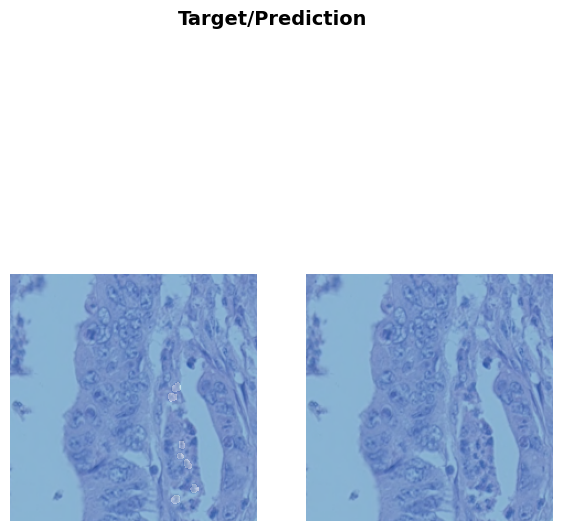

In [63]:
# Show the results
learn.show_results(max_n=1, figsize=(7,8))

In [73]:
# ALL MASKS
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time


AttributeError: 'int' object has no attribute 'stored'